## Housing Price -- Data Crawling & Analysis
## RUC-Tree

## Step 1: Import necessary packages

In [64]:
from selenium import webdriver
from time import sleep
import pandas as pd
import re
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from selenium.webdriver.support import expected_conditions as EC
from selenium.common import NoSuchElementException
from selenium.webdriver.common.by import By
from matplotlib import style
import jieba
print(plt.style.available)
%matplotlib inline

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Step 2: Use webdriver to locate the selected block
### My Block：Chaoyang, Olympic Park

In [ ]:
# locate the url
driver=webdriver.Edge()
url='https://esf.fang.com/'
driver.get(url)

# click my block
try:
    block_fixed =driver.find_element('partial link text','朝阳')
    block_fixed.click()
except NoSuchElementException:
    print('Failed to locate the block')

try:
    area_fixed =driver.find_element('partial link text','奥林匹克公园')
    area_fixed.click()
except NosuchElementException:
    print('Failed to locate the area')

## Step 3: Data Mining and processing

In [ ]:
def get_subway(target_str):
    '''
    Enter a target string to represent the extraction element name: this function enters '.bg_none.icon_dt'
    and returns a list for each web page, extracting the distance of the house to the nearest subway station
    in meters, and storing the contents as an integer with a missing value of -1.
    '''
    info_tag = driver.find_elements(By.CSS_SELECTOR, '.clearfix.label')
    info_sub =[]
    for item in info_tag:
        if len(item.find_elements(By.CSS_SELECTOR,'.bg_none.icon_dt'))!=0:
            str_dta_init =item.find_elements(By.CSS_SELECTOR,'.bg_none.icon_dt')[0].get_attribute('innerText')
            distance = eval(jieba.lcut(str_dta_init)[-2])
        else:
            distance=-1
        info_sub.append(distance)
    return info_sub

In [ ]:
# create two empty lists to store the house information and subway distance
initial_data=[]
subway_list=[]
# use css_selector to locate the house information
while True:
    try:
        # price info, basic info, location info, subway info
        info_price = driver.find_elements(By.CSS_SELECTOR, '.price_right')       
        info_basic = driver.find_elements(By.CSS_SELECTOR, '.tel_shop')
        info_location = driver.find_elements(By.CSS_SELECTOR, '.add_shop')
        subway= get_subway('.bg_none.icon_dt')
        subway_list.append(subway)    
        # use tqdm to show the progress
        for i in tqdm(range(len(info_basic)), desc="Progress"):
            dv_info_basic = info_basic[i].get_attribute('innerText').split('|')
            length = len(dv_info_basic)
            # complete the text processing
            housetype = dv_info_basic[0].replace(" ",'')
            area = float(dv_info_basic[1].replace(" ",'')[:-1])
            floor = dv_info_basic[2].replace(" ",'')
            orientation = dv_info_basic[3].replace(" ",'')[:-1]
            # finer processing
            if length == 6:
                year = int(float(dv_info_basic[4].replace(" ",'')[:-2]))
                broker = dv_info_basic[5].replace(" ",'')
            elif length == 5:
                last = dv_info_basic[4].replace(" ",'')
                if '年' in last:
                    year = int(float(last[:-2]))
                    broker = 'None'
                else:
                    year = 'NaN'
                    broker = last
            else:
                year = 'NaN'
                broker = 'None'
            # location information processing
            community = info_location[i].get_attribute('innerText').split('\n')[0]
            location = info_location[i].get_attribute('innerText').split('\n')[1][:-1]
            # price information processing
            total_price = int(info_price[i].get_attribute('innerText').split('\n')[0][:-1])
            unit_price = int(info_price[i].get_attribute('innerText').split('\n')[1][:-3])
            # concat all the information
            house_data = [total_price, unit_price,housetype, area, floor, orientation, year, broker, 
                            community, location]
            initial_data.append(house_data)         
    except NoSuchElementException:
        print('Input Error')
    # click the next page  
    try:
        next_page = driver.find_element(By.PARTIAL_LINK_TEXT, '下一页')
        next_page.click()
    except NoSuchElementException:
        print('Done')
        break

Progress: 100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.88it/s]


Done


In [ ]:
# close the driver
driver.quit()
# rename each column
column_names = ['Total_Price(万元)','Unit_Housing_Price(元/m^2)', 'Room(户型)', 'Area(m^2)', 'Floor(层数)', 
                'Orientation(朝向)', 'Time(建成时间)', 'Broker(经纪人)', 'Community(小区)', 'Location(地址)']
data=pd.DataFrame(initial_data, columns= column_names)
# merge the lists
merged_subway_list=[]
for sublist in subway_list:
    merged_subway_list.extend(sublist)
data['Subway[最近地铁站距离(m)]'] = merged_subway_list
data

,Total_Price(万元),Unit_Housing_Price(元/m^2),Room(户型),Area(m^2),Floor(层数),Orientation(朝向),Time(建成时间),Broker(经纪人),Community(小区),Location(地址),Subway[最近地铁站距离(m)]
0,2100,170731,3室2厅,123.00,顶层（共6层）,南北,2008,王伟,国奥村,奥林匹克公园-林萃东路1号,-1
1,1699,107838,3室2厅,157.55,高层（共14层）,南北,2008,王伟,美伦堡,奥林匹克公园-科荟路51,1044
2,2600,126829,3室2厅,205.00,高层（共6层）,南北,2008,秦明月,国奥村,奥林匹克公园-林萃东路1号,-1
3,2700,122171,3室0厅,221.00,底层（共9层）,南,NaN,齐胜,国奥村,奥林匹克公园-林萃东路1号,-1
4,2000,155171,2室2厅,128.89,高层（共6层）,南北,2008,秦明月,国奥村,奥林匹克公园-林萃东路1号,-1
...,...,...,...,...,...,...,...,...,...,...,...
1331,1400,100842,3室1厅,138.83,高层（共15层）,南北,2008,None,融域,奥林匹克公园-域清街2号,874
1332,510,88757,1室1厅,57.46,中层（共6层）,南北,2001,None,澳林春天一期,奥林匹克公园-林翠西,1063
1333,2500,108832,4室2厅,229.71,底层（共9层）,南北,NaN,None,国奥村,奥林匹克公园-林萃东路1号,-1
1334,520,74938,1室1厅,69.39,低层（共15层）,西,2003,None,裕瑞轩,奥林匹克公园-花虎沟36,-1


## Step 4: Data Merging

In [ ]:
# export the excel
data.to_excel('Chaoyang_Olympic.xlsx', index=False)

In [ ]:
# read the merged excel
merged_data = pd.read_excel('Chaoyang_Merged.xlsx')
merged_data

,Block,Total_Price(万元),Unit_Housing_Price(元/m^2),Room(户型),Area(m^2),Floor(层数),Orientation(朝向),Time(建成时间),Broker(经纪人),Community(小区),Location(地址),Subway[最近地铁站距离(m)]
0,Anzhen,400万,69541,2室1厅,57.52㎡,高层 （共6层）,南北向,1979年建,陈强,胜古南里,安贞-北京朝阳区北三环东路胜古南里,\n距5号线和平西桥站约465米
1,Anzhen,548万,71326,3室1厅,76.83㎡,高层 （共6层）,南北向,1985年建,陈强,安华西里,安贞-黄寺大街外馆斜街交接口往西300米附近,\n距8号线安华桥站约809米
2,Anzhen,380万,65687,2室1厅,57.85㎡,中层 （共6层）,东西向,1987年建,陈强,安华里,安贞-安华里,\n距10号线安贞门站约1081米
3,Anzhen,968万,93157,2室1厅,103.91㎡,低层 （共17层）,南北向,2005年建,陈强,国典华园,安贞-朝阳区北三环安贞桥北400米安定路12号,\n距5号线惠新西街南口站约658米
4,Anzhen,530万,85718,2室1厅,61.83㎡,高层 （共13层）,南北向,1992年建,王杨,安华西里,安贞-黄寺大街外馆斜街交接口往西300米附近,\n\n\n\n\n距8号线安华桥站约809米
...,...,...,...,...,...,...,...,...,...,...,...,...
4693,Baiziwan,970,67511,NaN,143.68,NaN,NaN,2008,NaN,百子湾西里,百子湾-百子湾西里,一拍
4694,Baiziwan,970,67511,NaN,143.68,NaN,NaN,2008,NaN,百子湾西里,百子湾-百子湾西里,一拍
4695,Baiziwan,970,67511,NaN,143.68,NaN,NaN,2008,NaN,百子湾西里,百子湾-百子湾西里,一拍
4696,Baiziwan,970,67511,NaN,143.68,NaN,NaN,2008,NaN,百子湾西里,百子湾-百子湾西里,一拍


In [ ]:
# Data cleaning
merged_data['Area(m^2)'] = merged_data['Area(m^2)'].astype(str).str.replace('㎡', '').str.strip()
merged_data['Area(m^2)'] = merged_data['Area(m^2)'].apply(lambda x: float(x) if x else None)
merged_data['Total_Price(万元)'] = merged_data['Total_Price(万元)'].astype(str).str.replace('万', '').str.strip()
merged_data['Total_Price(万元)'] = merged_data['Total_Price(万元)'].apply(lambda x: float(x) if x else None)
merged_data['Orientation(朝向)'] = merged_data['Orientation(朝向)'].astype(str).str.replace('向', '').str.strip()
merged_data['Time(建成时间)'] = merged_data['Time(建成时间)'].astype(str).str.replace('年建', '').str.strip()
merged_data['Time(建成时间)'] = merged_data['Time(建成时间)'].apply(lambda x: float(x) if x else None)
merged_data


,Block,Total_Price(万元),Unit_Housing_Price(元/m^2),Room(户型),Area(m^2),Floor(层数),Orientation(朝向),Time(建成时间),Broker(经纪人),Community(小区),Location(地址),Subway[最近地铁站距离(m)]
0,Anzhen,400.00,69541,2室1厅,57.52,高层 （共6层）,南北,1979.00,陈强,胜古南里,安贞-北京朝阳区北三环东路胜古南里,\n距5号线和平西桥站约465米
1,Anzhen,548.00,71326,3室1厅,76.83,高层 （共6层）,南北,1985.00,陈强,安华西里,安贞-黄寺大街外馆斜街交接口往西300米附近,\n距8号线安华桥站约809米
2,Anzhen,380.00,65687,2室1厅,57.85,中层 （共6层）,东西,1987.00,陈强,安华里,安贞-安华里,\n距10号线安贞门站约1081米
3,Anzhen,968.00,93157,2室1厅,103.91,低层 （共17层）,南北,2005.00,陈强,国典华园,安贞-朝阳区北三环安贞桥北400米安定路12号,\n距5号线惠新西街南口站约658米
4,Anzhen,530.00,85718,2室1厅,61.83,高层 （共13层）,南北,1992.00,王杨,安华西里,安贞-黄寺大街外馆斜街交接口往西300米附近,\n\n\n\n\n距8号线安华桥站约809米
...,...,...,...,...,...,...,...,...,...,...,...,...
4693,Baiziwan,970.00,67511,NaN,143.68,NaN,nan,2008.00,NaN,百子湾西里,百子湾-百子湾西里,一拍
4694,Baiziwan,970.00,67511,NaN,143.68,NaN,nan,2008.00,NaN,百子湾西里,百子湾-百子湾西里,一拍
4695,Baiziwan,970.00,67511,NaN,143.68,NaN,nan,2008.00,NaN,百子湾西里,百子湾-百子湾西里,一拍
4696,Baiziwan,970.00,67511,NaN,143.68,NaN,nan,2008.00,NaN,百子湾西里,百子湾-百子湾西里,一拍


In [ ]:
# drop the duplicate rows
duplicate_rows = merged_data[merged_data.duplicated()]
if merged_data.duplicated().sum() == 0:
    print('No duplicate')
else:
    print('Duplicate:')
    print(duplicate_rows)
merged_data.drop_duplicates(inplace=True,keep='first')

Duplicate:
         Block  Total_Price(万元)  Unit_Housing_Price(元/m^2) Room(户型)  \
70      Anzhen          1450.00                     112289    3室1厅    
86      Anzhen           570.00                      93734    2室1厅    
88      Anzhen           375.00                      76546    1室1厅    
94      Anzhen           798.00                      58560    3室2厅    
121     Anzhen           935.00                     105115    2室1厅    
...        ...              ...                        ...      ...   
4692  Baiziwan           970.00                      67511      NaN   
4693  Baiziwan           970.00                      67511      NaN   
4694  Baiziwan           970.00                      67511      NaN   
4695  Baiziwan           970.00                      67511      NaN   
4696  Baiziwan           970.00                      67511      NaN   

      Area(m^2)    Floor(层数) Orientation(朝向)  Time(建成时间) Broker(经纪人)  \
70       129.13   高层 （共16层）               东南     2005.00        

In [53]:
group_data = pd.DataFrame(merged_data)
group_data

,Block,Total_Price(万元),Unit_Housing_Price(元/m^2),Room(户型),Area(m^2),Floor(层数),Orientation(朝向),Time(建成时间),Broker(经纪人),Community(小区),Location(地址),Subway[最近地铁站距离(m)]
0,Anzhen,400.00,69541,2室1厅,57.52,高层 （共6层）,南北,1979.00,陈强,胜古南里,安贞-北京朝阳区北三环东路胜古南里,\n距5号线和平西桥站约465米
1,Anzhen,548.00,71326,3室1厅,76.83,高层 （共6层）,南北,1985.00,陈强,安华西里,安贞-黄寺大街外馆斜街交接口往西300米附近,\n距8号线安华桥站约809米
2,Anzhen,380.00,65687,2室1厅,57.85,中层 （共6层）,东西,1987.00,陈强,安华里,安贞-安华里,\n距10号线安贞门站约1081米
3,Anzhen,968.00,93157,2室1厅,103.91,低层 （共17层）,南北,2005.00,陈强,国典华园,安贞-朝阳区北三环安贞桥北400米安定路12号,\n距5号线惠新西街南口站约658米
4,Anzhen,530.00,85718,2室1厅,61.83,高层 （共13层）,南北,1992.00,王杨,安华西里,安贞-黄寺大街外馆斜街交接口往西300米附近,\n\n\n\n\n距8号线安华桥站约809米
...,...,...,...,...,...,...,...,...,...,...,...,...
4684,Baiziwan,970.00,67511,3室1厅,143.68,低层 （共18层）,南,2008.00,NaN,沿海赛洛城,百子湾-广渠东路33号,距7号线百子湾站约762米
4687,Baiziwan,970.00,67511,1室1厅,143.68,底层 （共18层）,北,2008.00,NaN,后现代城,百子湾-百子湾路16号,距7号线大郊亭站约843米
4688,Baiziwan,970.00,67511,1室1厅,143.68,中层 （共24层）,南,2008.00,NaN,沿海赛洛城,百子湾-广渠东路33号,距7号线百子湾站约762米
4689,Baiziwan,970.00,67511,NaN,143.68,NaN,nan,2008.00,NaN,百子湾西里,百子湾-百子湾西里,一拍


## Step 5: Data Analysis

#### 5-1：Data Description

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
display(group_data.describe(include='all'))

,Block,Total_Price(万元),Unit_Housing_Price(元/m^2),Room(户型),Area(m^2),Floor(层数),Orientation(朝向),Time(建成时间),Broker(经纪人),Community(小区),Location(地址),Subway[最近地铁站距离(m)]
count,2955,2955.00,2955.00,2951,2955.00,2943,2955,2906.00,2825,2955,2955,2808
unique,3,NaN,NaN,39,NaN,184,11,NaN,156,84,76,92
top,Baiziwan,NaN,NaN,2室1厅,NaN,中层 （共18层）,南北,NaN,omit,沿海赛洛城,百子湾-广渠东路33号,距7号线百子湾站约762米
freq,1574,NaN,NaN,723,NaN,94,1524,NaN,404,323,323,323
mean,NaN,1148.39,82283.97,NaN,135.65,NaN,NaN,2005.47,NaN,NaN,NaN,NaN
std,NaN,649.64,22646.80,NaN,45.54,NaN,NaN,8.87,NaN,NaN,NaN,NaN
min,NaN,175.00,38742.00,NaN,33.70,NaN,NaN,1963.00,NaN,NaN,NaN,NaN
25%,NaN,970.00,67511.00,NaN,119.11,NaN,NaN,2005.00,NaN,NaN,NaN,NaN
50%,NaN,970.00,67511.00,NaN,143.68,NaN,NaN,2008.00,NaN,NaN,NaN,NaN
75%,NaN,1059.50,94490.50,NaN,143.68,NaN,NaN,2008.00,NaN,NaN,NaN,NaN


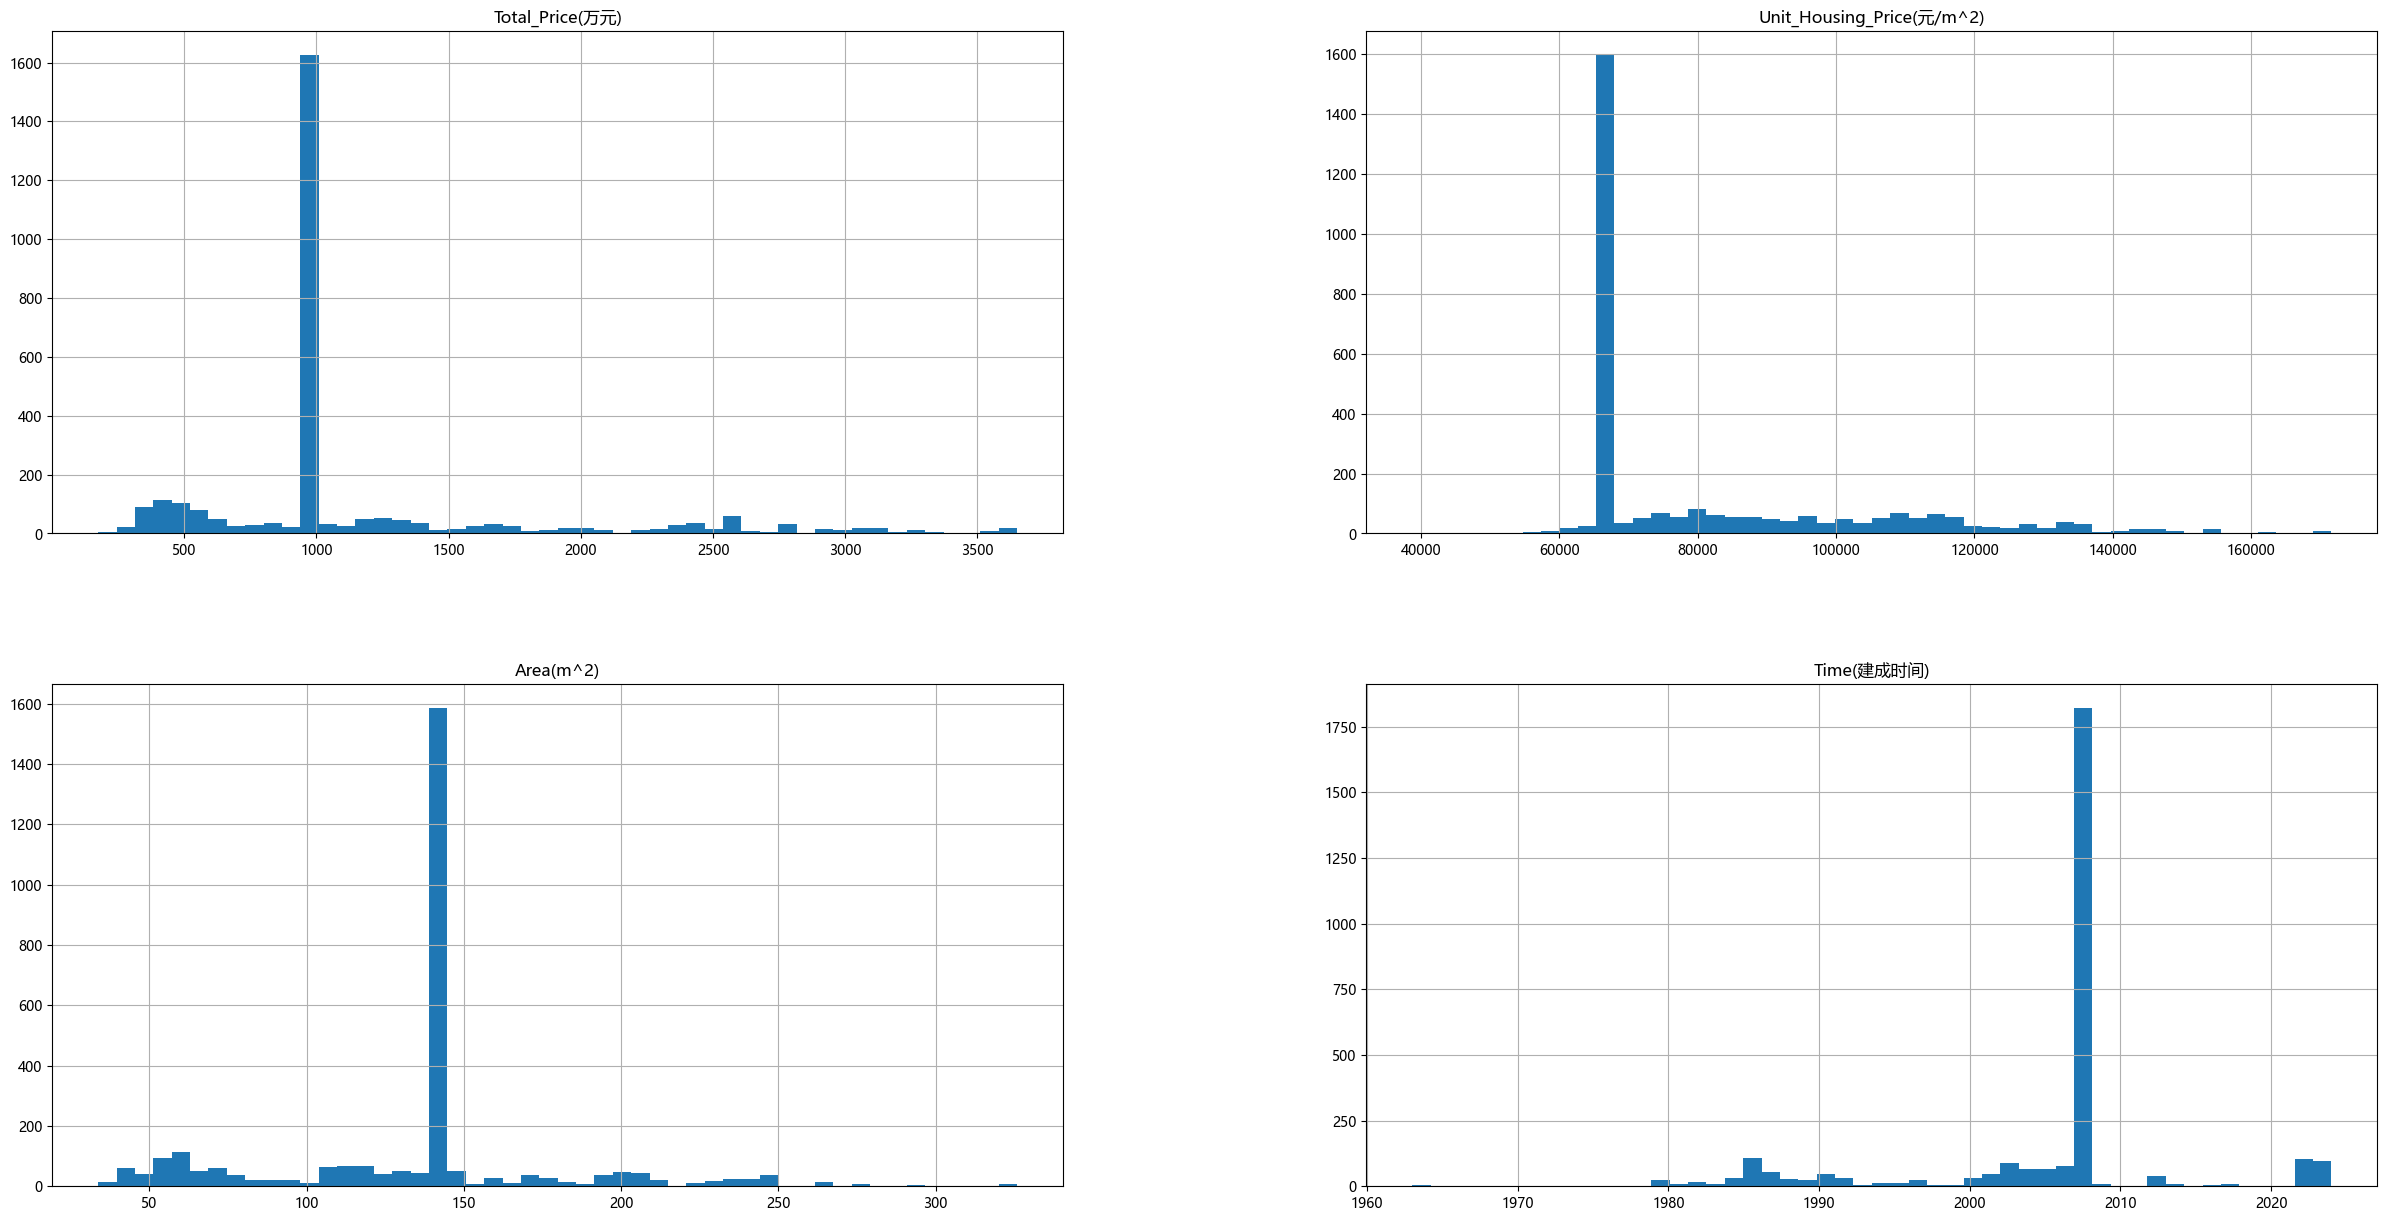

In [ ]:
## draw the histogram
group_data.hist(bins=50, figsize=(30,15))
plt.show()

#### 5-2: Distribution Graph

Room Counts:
Room(户型)
2室1厅     723
1室1厅     425
3室2厅     319
3室2厅     274
3室1厅     247
4室2厅     161
2室2厅     135
2室2厅     126
2室1厅      99
4室2厅      82
1室0厅      77
1室1厅      33
5室2厅      33
3室1厅      29
4室1厅      27
3室0厅      19
5室3厅      18
5室2厅      18
1室2厅      13
4室0厅      12
5室1厅      11
4室3厅      11
3室0厅       9
独栋         8
4室3厅       8
3室3厅       7
4室0厅       4
5室0厅       3
6室2厅       3
2室3厅       3
8室3厅       2
2室0厅       2
0室1厅       2
6室3厅       2
6室2厅       2
4室4厅       1
5室3厅       1
6室3厅       1
5室1厅       1
Name: count, dtype: int64


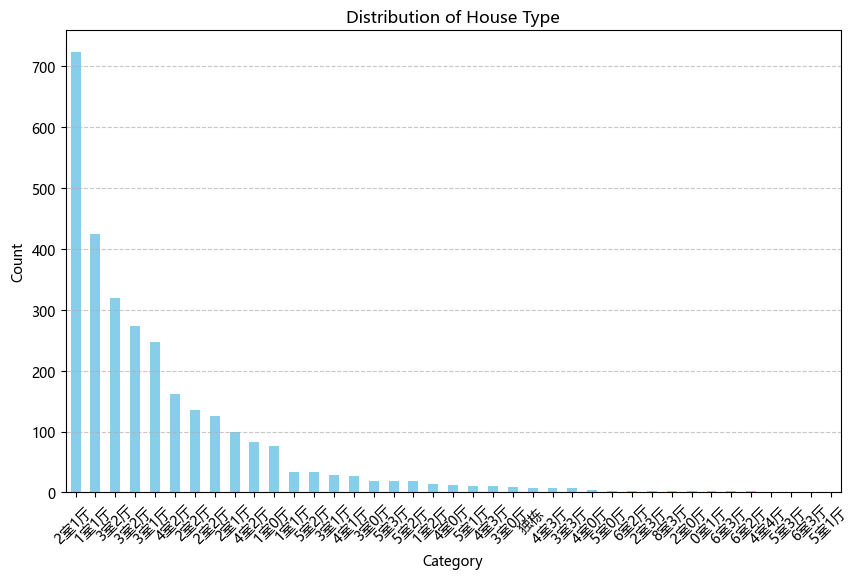

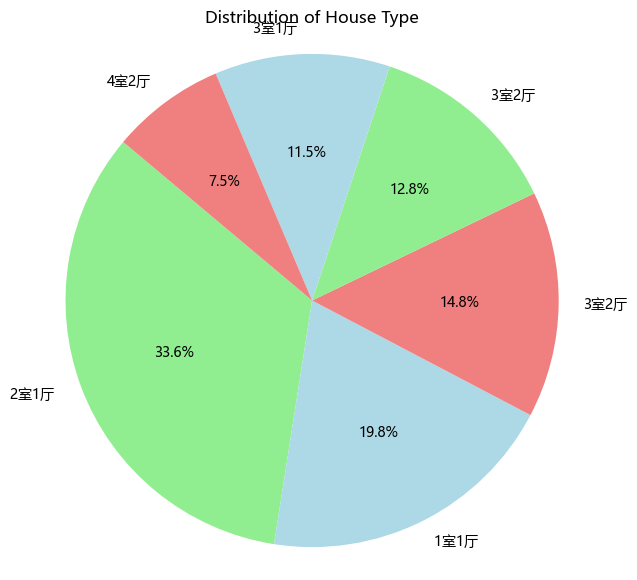

In [ ]:
# discribe the house type
# set the font 
font_name = 'Microsoft YaHei'
plt.rcParams['font.family'] = font_name

# count all the types
room_counts = group_data['Room(户型)'].value_counts()
print("Room Counts:")
print(room_counts)

# draw the bar chart
plt.figure(figsize=(10, 6))
room_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of House Type')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # 旋转 x 轴标签，以避免重叠
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 添加网格线
plt.show()

# draw the pie chart
# set the threshold for display
threshold = 5
total = room_counts.sum()
room_counts = room_counts[room_counts / total * 100 >= threshold]
plt.figure(figsize=(7, 7))
plt.pie(room_counts, labels=room_counts.index, autopct=lambda p: '{:.1f}%'.format(p) 
        if p > threshold else '', startangle=140, colors=['lightgreen', 'lightblue', 'lightcoral'])
plt.title('Distribution of House Type')
plt.axis('equal')  
plt.show()

#### 5-3: Median unit price/total price: District bar chart

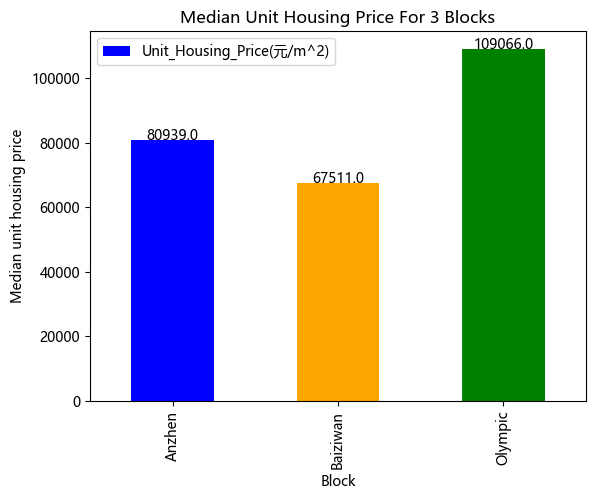

In [ ]:
# count the unit housing price in each block
median_unit_prices = group_data.groupby('Block')['Unit_Housing_Price(元/m^2)'].median()

# draw the chart
median_unit_prices.plot(kind='bar', color=['blue', 'orange', 'green'])

for i, v in enumerate(median_unit_prices):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.title('Median Unit Housing Price For 3 Blocks')
plt.xlabel('Block')
plt.ylabel('Median unit housing price')
plt.legend()
plt.show()

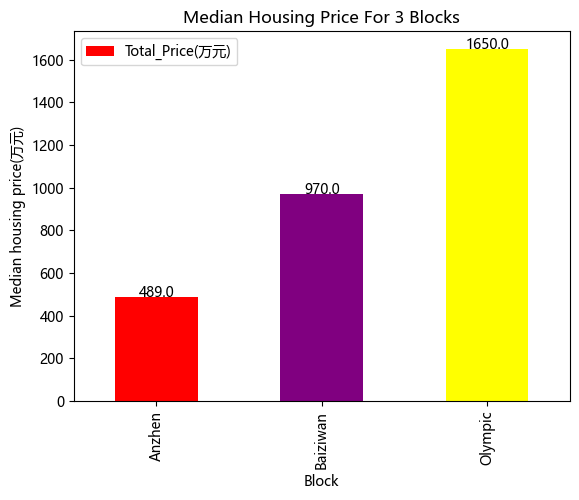

In [ ]:
# count the median total price in each block
plt.rcParams['font.family'] = font_name
median_prices = group_data.groupby('Block')['Total_Price(万元)'].median()

# draw the chart
median_prices.plot(kind='bar', color=['red', 'purple', 'yellow'])

for i, v in enumerate(median_prices):
    plt.text(i, v + 0.1, str(v), ha='center')
plt.title('Median Housing Price For 3 Blocks')
plt.xlabel('Block')
plt.ylabel('Median housing price(万元)')
plt.legend()
plt.show()